<a href="https://colab.research.google.com/github/capajaro/Data_Mining_Project-/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np 
import pandas as pd
import os

import string
!pip install emoji
import emoji
import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud



# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#For Stemming, NLTK is needed
import nltk
from nltk.stem.snowball import SnowballStemmer
# tools for text processing
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import spacy


     |â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 133kB 8.6MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df_train = pd.read_csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/test.csv')

df_train.isnull().sum()
df_test.isnull().sum()

count = df_train['text'].str.split().str.len()
count
print(max(count))

31


Train dataset shape :  (7613, 5)
Test dataset shape :  (3263, 4)


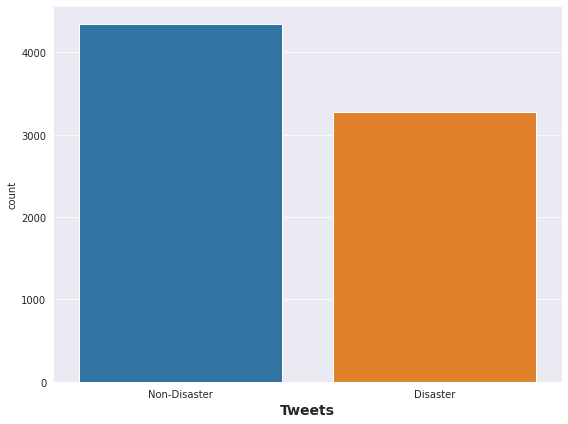

In [7]:
df_train[df_train.keyword.isnull()==False]
print("Train dataset shape : ",df_train.shape)
print("Test dataset shape : ",df_test.shape)

df_train['target'].value_counts()

#distribution reviews
sns.set_style("darkgrid")
plt.figure(num=10, figsize=(8, 6))
sns.countplot(x=df_train.target)
plt.xlabel('Tweets', fontweight='bold', fontsize= 14)
plt.xticks(ticks = [0,1], labels = ["Non-Disaster", "Disaster"])
plt.tight_layout()

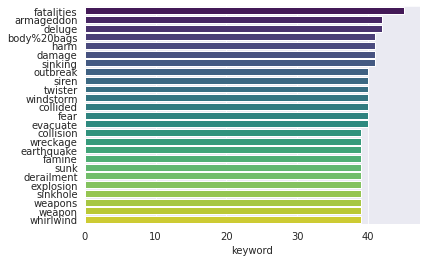

In [8]:
df_train['keyword'].value_counts()
sns.barplot(y=df_train['keyword'].value_counts()[:25].index,x=df_train['keyword'].value_counts()[:25], orient='horizontal', palette='viridis')

In [9]:
# A disaster tweet
disaster_tweets = df_train[df_train['target']==1]['text']
print('Examples of disaster tweets')
print(disaster_tweets.values[:5])

# A non-disaster tweet
non_disaster_tweets = df_train[df_train['target']==0]['text']
print('\n\nExamples of non-disaster tweets')
print(non_disaster_tweets.values[:5])

Examples of disaster tweets
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


Examples of non-disaster tweets
["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']


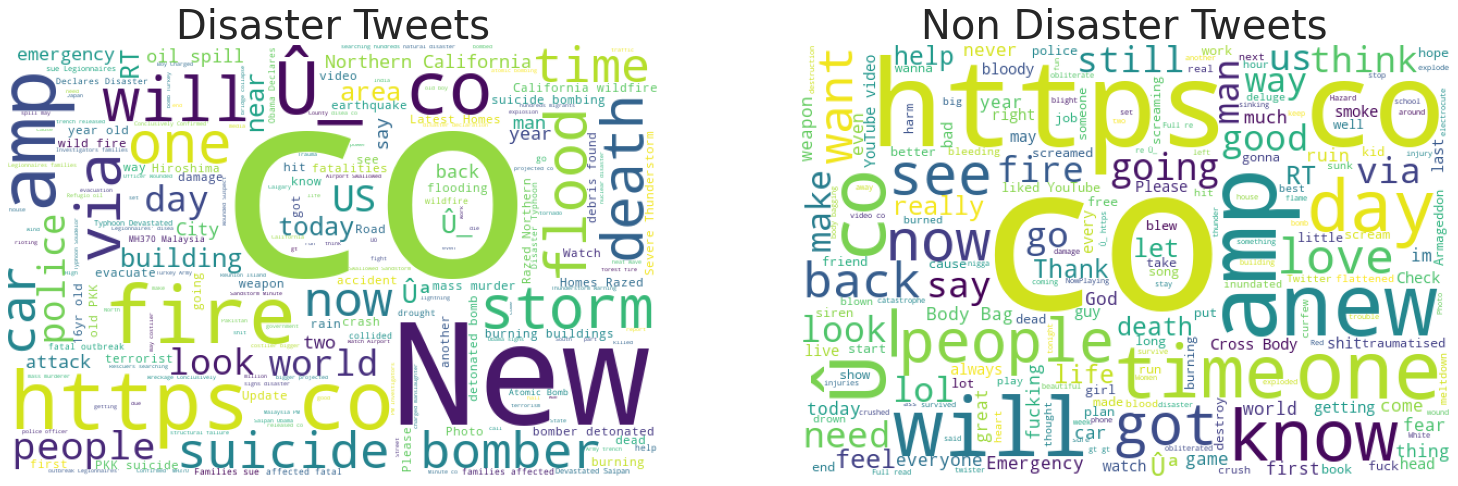

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [11]:
stop_words = stopwords.words('english') + ["u", "im", "ur", "dont", "doin", "ure"]

In [12]:
def clean(text):
    text = text.lower() #Lets make it lowercase
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeEmojis(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text

def removeStopwords(text):
    #Se definen las frases a filtrar
    stop_words = stopwords.words('english') + ["u", "im", "ur", "dont", "doin", "ure"]
    clean_text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return clean_text

def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def removeEmojis(text):
    allchars = [c for c in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI["en"]]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

test_string = "Hi ðŸ™ˆ 99 girls are running"
(test_string,removeNumbers(test_string))

def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    #https? will match both http and https
    #A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B.
    #\S Matches any character which is not a whitespace character.
    #+ Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match â€˜aâ€™ followed by any non-zero number of â€˜bâ€™s; it will not match just â€˜aâ€™.
    return clean_text

In [13]:
print("Text before removeStopwords function: " + df_train['text'][1])
print("Text after removeStopwords function: " + removeStopwords(df_train['text'][1]))

def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

print("Text before removePunctuations function: " + df_train['text'][1])
print("Text after removePunctuations function: " + removePunctuations(df_train['text'][1]))



Text before removeStopwords function: Forest fire near La Ronge Sask. Canada
Text after removeStopwords function: Forest fire near La Ronge Sask. Canada
Text before removePunctuations function: Forest fire near La Ronge Sask. Canada
Text after removePunctuations function: Forest fire near La Ronge Sask Canada


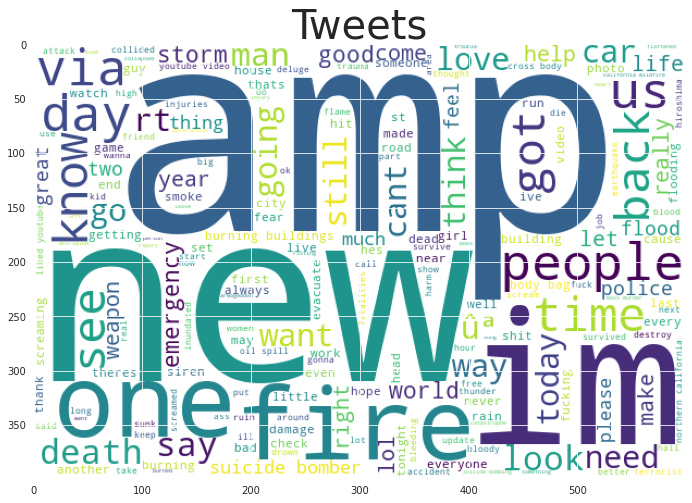

In [15]:
df_train['clean_text']=df_train.text.apply(clean)
df_test['clean_text']=df_test.text.apply(clean)

tweets = df_train['clean_text']
fig, ax1, = plt.subplots(1,  figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(tweets))
ax1.imshow(wordcloud1)
ax1.axis('on')
ax1.set_title('Tweets',fontsize=40);

In [16]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
df_train.at[df_train['id'].isin(ids_with_target_error),'target'] = 0
df_train[df_train['id'].isin(ids_with_target_error)]

id  ...                                         clean_text
229    328  ...                    ready get annihilated bucs game
301    443  ...  short reading apocalypse  in spirit angel took...
356    513  ...  build army  dogs leader lion dogs fight like lion
1822  2619  ...  ipod crashed weloveyoulouis mtvhottest one dir...
2536  3640  ...  desperation dislocation separation condemnatio...
2715  3900  ...  man currensy really talkin talk id devastated ...
3024  4342  ...  going fest bring swimming goggles dust storm c...
4068  5781  ...  campsite recommendations toilets shower pub fi...
4609  6552  ...  prediction vikings game sundaydont expect whol...
4611  6554  ...  dante exums knee injury could stem jazzs hoped...
4622  6570  ...               sporten linked arsenal causes injury
4713  6701  ...                      imagine room walls lava lamps
4714  6702  ...  sunset looked like erupting volcano initial th...
4732  6729  ...              check lava lamp dude httptcotoviqoofv
4820  6861  ...  abortion murder blowjobs cannibalism masturbat...
5068  7226  ...  course one day dress professionally aka unsens...

[16 rows x 6 columns]

In [19]:
df_train = df_train.drop_duplicates(subset = ['clean_text', 'target'])
df_test = df_train.drop_duplicates(subset = ['clean_text'])

In [20]:
print(df_train.shape)


(7494, 6)


## Abreviations

In [21]:
abbreviations = {
    "$" : " dollar ",
    "â‚¬" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

## Continue coding

In [22]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [23]:
df_train['clean_text']=df_train.clean_text.apply(convert_abbrev)
df_test['clean_text']=df_test.clean_text.apply(convert_abbrev)

In [24]:
text = df_train['clean_text']
vectorizer = CountVectorizer()
vectorizer.fit(text)
print(vectorizer.vocabulary_['cooool'])
print(vectorizer.vocabulary_['cool'])

3146
3140


In [25]:
stemmer = SnowballStemmer(language='english')

tokens = df_train['text'][1].split()
clean_text = ' '

for token in tokens:
    print(token + ' --> ' + stemmer.stem(token))

Forest --> forest
fire --> fire
near --> near
La --> la
Ronge --> rong
Sask. --> sask.
Canada --> canada


In [26]:
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

print("Text before stemWord function: " + df_train['text'][1])
print("Text after stemWord function: " + stemWord(df_train['text'][1]))

Text before stemWord function: Forest fire near La Ronge Sask. Canada
Text after stemWord function:   forest fire near la rong sask. canada


In [28]:
df_train['clean_text']=df_train.text.apply(stemWord)
df_test['clean_text']=df_test.text.apply(stemWord)

In [29]:
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text

In [30]:
df_train['clean_text']=df_train.text.apply(lemmatizeWord)
df_test['clean_text']=df_test.text.apply(lemmatizeWord)

NameError: ignored